In [1]:
# Raster processing script 
# Author: Ben Kraas
# Coding assistant: Github Copilot

# imports
from datetime import datetime
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import re

In [37]:
# Get script directory
script_dir = Path("")

# load all five raster files (NDVI)
raster_folder = script_dir / "data" / "source" / "ndvi-means-100m-tif"

# iterate over all files in the folder, load the rasters and store the data and metadata in a dictionary
rasters = {}
n_images = 0
for raster_file in raster_folder.glob("*.tif"):
    # open the raster file
    with rasterio.open(raster_file) as src:
        # read the data
        data = src.read(1)
        # print the metadata
        print(f"File loaded: {raster_file.name}")
        print(f"Data type: {data.dtype}")
        print(f"Shape: {data.shape}")
        print(f"CRS: {src.crs}")
        
        # get year and month seperately from the filename
        match = re.search(r"(\d{4})_(\d{2})", raster_file.name)
        if match:
            year = int(match.group(1))
            month = int(match.group(2))
        else:
            print(f"Could not extract year and month from filename: {raster_file.name}")
            continue

        # ensure the year key exists in the dictionary
        if year not in rasters:
            rasters[year] = {}

        # add the data to the dictionary
        rasters[year][month] = {
            "data": data,
            "metadata": {
                "name": raster_file.name,
                "crs": src.crs.to_proj4(),
                "transform": src.transform,
                "bounds": src.bounds,
                "width": src.width,
                "height": src.height,
            }
        }
        n_images += 1

# Create a list with all the years and months as sublists - but sorted by date
years = sorted(rasters.keys())
monthlist_sorted = []
for year in years:
    for month in sorted(rasters[year].keys()):
        monthlist_sorted.append((year, month))
# Print the years and months
print("Years and months:")
for year, month in monthlist_sorted:
    print(f"{year}-{month:02d}")

print(f"\nSucces, Number of images loaded: {n_images}. Total size: {len(rasters)} years, {sum(len(v) for v in rasters.values())} months.")



File loaded: ndvi_2020_06.tif
Data type: float32
Shape: (906, 1614)
CRS: EPSG:4326
File loaded: ndvi_2023_03.tif
Data type: float32
Shape: (906, 1614)
CRS: EPSG:4326
File loaded: ndvi_2024_09.tif
Data type: float32
Shape: (906, 1614)
CRS: EPSG:4326
File loaded: ndvi_2024_06.tif
Data type: float32
Shape: (906, 1614)
CRS: EPSG:4326
File loaded: ndvi_2020_09.tif
Data type: float32
Shape: (906, 1614)
CRS: EPSG:4326
File loaded: ndvi_2020_03.tif
Data type: float32
Shape: (906, 1614)
CRS: EPSG:4326
File loaded: ndvi_2020_12.tif
Data type: float32
Shape: (906, 1614)
CRS: EPSG:4326
File loaded: ndvi_2023_06.tif
Data type: float32
Shape: (906, 1614)
CRS: EPSG:4326
File loaded: ndvi_2022_12.tif
Data type: float32
Shape: (906, 1614)
CRS: EPSG:4326
File loaded: ndvi_2021_03.tif
Data type: float32
Shape: (906, 1614)
CRS: EPSG:4326
File loaded: ndvi_2023_09.tif
Data type: float32
Shape: (906, 1614)
CRS: EPSG:4326
File loaded: ndvi_2021_06.tif
Data type: float32
Shape: (906, 1614)
CRS: EPSG:4326
File

In [38]:
# Calculate NDVI difference on pixel-level
ndvi_diff = []  # this should yield a total of four rasters
raster_years = sorted(rasters.keys())  # Sort years to ensure correct order
for year, month in monthlist_sorted:
    if year + 1 in rasters and month in rasters[year] and month in rasters[year + 1]:
        current_data = rasters[year][month]["data"]
        next_data = rasters[year + 1][month]["data"]
        ndvi_diff.append(next_data - current_data)

print(f"Success: Number of NDVI differences: {len(ndvi_diff)}, Shapes: {[r.shape for r in ndvi_diff]}")

# Flatten the list of NDVI differences for boxplot
ndvi_diff_flat = [arr.ravel() for arr in ndvi_diff]

# Create a subsample of random values for better performance in the boxplots (48M values (many NaN) x4 is a bit much)
# Sample 10,00 random values from each NDVI difference array
ndvi_diff_sampled = []
for arr in ndvi_diff:
    flat = arr.ravel()
    flat = flat[~np.isnan(flat)]  # Remove NaNs

    if flat.size > 1000:
        sample = np.random.choice(flat, 1000, replace=False)
    else:
        sample = flat

    ndvi_diff_sampled.append(sample)

Success: Number of NDVI differences: 14, Shapes: [(906, 1614), (906, 1614), (906, 1614), (906, 1614), (906, 1614), (906, 1614), (906, 1614), (906, 1614), (906, 1614), (906, 1614), (906, 1614), (906, 1614), (906, 1614), (906, 1614)]


In [ ]:
# Adjust the dictionary structure to include layers for each year with the POWER of list comprehension! Yes, AI helped me with this!
stat_summary = {
    "actual": {
        "mean": {year: {month: np.nanmean(rasters[year][month]["data"]) for month in rasters[year]} for year in raster_years},
        "min":  {year: {month: np.nanmin(rasters[year][month]["data"]) for month in rasters[year]} for year in raster_years},
        "max":  {year: {month: np.nanmax(rasters[year][month]["data"]) for month in rasters[year]} for year in raster_years},
        "std":  {year: {month: np.nanstd(rasters[year][month]["data"]) for month in rasters[year]} for year in raster_years},
    },
    "change": {
        "mean": {year: {month: np.nanmean(ndvi_diff[i]) for i, (y, month) in enumerate(monthlist_sorted) if y == year and i < len(ndvi_diff)} for year in raster_years[:-1]},
        "min":  {year: {month: np.nanmin(ndvi_diff[i]) for i, (y, month) in enumerate(monthlist_sorted) if y == year and i < len(ndvi_diff)} for year in raster_years[:-1]},
        "max":  {year: {month: np.nanmax(ndvi_diff[i]) for i, (y, month) in enumerate(monthlist_sorted) if y == year and i < len(ndvi_diff)} for year in raster_years[:-1]},
        "std":  {year: {month: np.nanstd(ndvi_diff[i]) for i, (y, month) in enumerate(monthlist_sorted) if y == year and i < len(ndvi_diff)} for year in raster_years[:-1]},
    }
}
print(f"Success: NDVI statistics calculated for {len(stat_summary['actual']['mean'])} years and {len(stat_summary['change']['mean'])} differences")

Success: NDVI statistics calculated for 5 years and 4 differences


In [41]:
# Serialize all float32 values to JSON-compatible floats
for category in stat_summary:
    for stat_type in stat_summary[category]:
        for year, month in monthlist_sorted:
            if year in stat_summary[category][stat_type] and month in stat_summary[category][stat_type][year]:
                stat_summary[category][stat_type][year][month] = float(stat_summary[category][stat_type][year][month])

# Print the statistics
print(json.dumps(stat_summary, indent=4))


{
    "actual": {
        "mean": {
            "2020": {
                "6": 0.5381625294685364,
                "9": 0.27168571949005127,
                "3": 0.3213536739349365,
                "12": 0.2095070779323578
            },
            "2021": {
                "3": 0.24356460571289062,
                "6": 0.6607979536056519,
                "12": 0.10680906474590302,
                "9": 0.36187517642974854
            },
            "2022": {
                "12": 0.19005724787712097,
                "9": 0.36411675810813904,
                "6": 0.5970573425292969,
                "3": 0.21411429345607758
            },
            "2023": {
                "3": 0.2220344841480255,
                "6": 0.6577891707420349,
                "9": 0.3818093240261078
            },
            "2024": {
                "9": 0.31525424122810364,
                "6": 0.43590253591537476,
                "12": 0.1868213266134262,
                "3": 0.20977796614170074
      

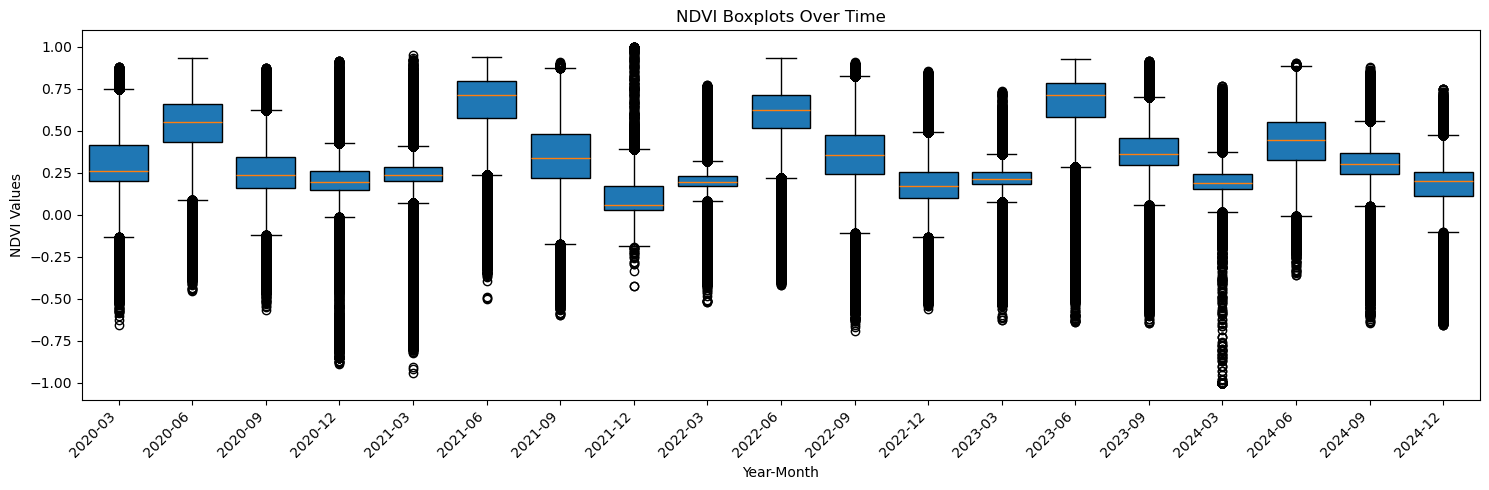

In [42]:
fig, ax = plt.subplots(figsize=(15, 5))

positions = []
labels = []

for position, (year, month) in enumerate(monthlist_sorted, start=1):
	if year in rasters and month in rasters[year]:
		# Flatten the data and remove NaN values
		data = rasters[year][month]["data"].ravel()
		data = data[~np.isnan(data)]
		
		# Add the position and label
		positions.append(position)
		labels.append(f"{year}-{month:02d}")
		
		# Create the boxplot with wider boxes
		ax.boxplot(data, positions=[position], vert=True, patch_artist=True, widths=0.8)

ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_xlabel("Year-Month")
ax.set_ylabel("NDVI Values")
ax.set_title("NDVI Boxplots Over Time")
plt.tight_layout()
plt.show()
